<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Code Readability Evals</h1>

Arize provides tooling to evaluate LLM applications, including tools to determine the readability or unreadability of code generated by LLM applications. 

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to classifying generated code as readable or unreadable using datasets with ground-truth labels
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [ ]:
!pip install -qq "arize-phoenix[experimental]==0.0.33rc6" ipython matplotlib openai pycm scikit-learn

In [11]:
import os
import pandas as pd
from getpass import getpass

import matplotlib.pyplot as plt
import openai
from phoenix.experimental.evals import (
    CODE_READABILITY_PROMPT_OUTPUT_MAP,
    CODE_READABILITY_PROMPT_TEMPLATE_STR,
    OpenAiModel,
    download_benchmark_dataset,
    llm_eval_binary,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in addition to an evaluation prompt template against benchmark datasets of queries and retrieved documents with ground-truth relevance labels. Currently supported datasets include:

- "wiki_qa-train"
- "ms_marco-v1.1-train"
- "code-readability-classification"

for the code-readability-classification dataset below, we'll randomly select either the "canonical_solution" or the "unreadable_solution" and set the "ground_truth" label to 1 if we selected the canonical solution and 0 if we selected the unreadable solution

In [2]:
dataset_name = "openai_humaneval_with_readability_v3"
df = download_benchmark_dataset(
    task="code-readability-classification", dataset_name=dataset_name
)

## Display Binary Relevance Classification Template

View the default template used to classify relevance. You can tweak this template and evaluate its performance relative to the default.

In [3]:
print(CODE_READABILITY_PROMPT_TEMPLATE_STR)


You are a stern but practical senior software engineer who cares a lot about simplicity and
readability of code. Can you review the following code that was written by another engineer?
Focus on readability of the code. Respond with "readable" if you think the code is readable,
or "unreadable" if the code is unreadable or needlessly complex for what it's trying
to accomplish.

ONLY respond with "readable" or "unreadable"

Task Assignment:
```
{query}
```

Implementation to Evaluate:
```
{code}
```



The template variables are:

- **query_text:** the coding task asked by a user
- **code:** implementation of the coding task

## Configure the LLM

Configure your OpenAI API key.

In [4]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

🔑 Enter your OpenAI API key: ········


Instantiate the LLM and set parameters.

In [17]:
model = OpenAiModel(
    model_name="gpt-3.5-turbo",
    temperature=0.0,
)

## Run Relevance Classifications

Run relevance classifications against a subset of the data.

In [18]:
df = df.sample(n=100).reset_index(drop=True)
df = df.rename(
    columns={"prompt": "query", "solution": "code"},
)

In [19]:
relevance_classifications = llm_eval_binary(
    dataframe=df,
    template=CODE_READABILITY_PROMPT_TEMPLATE_STR,
    model=model,
    rails=list(CODE_READABILITY_PROMPT_OUTPUT_MAP.values()),
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.73it/s]


## Evaluate Classifications

Evaluate the predictions against human-labeled ground-truth relevance labels.

              precision    recall  f1-score   support

    readable       0.83      0.94      0.88        52
  unreadable       0.93      0.79      0.85        48

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100



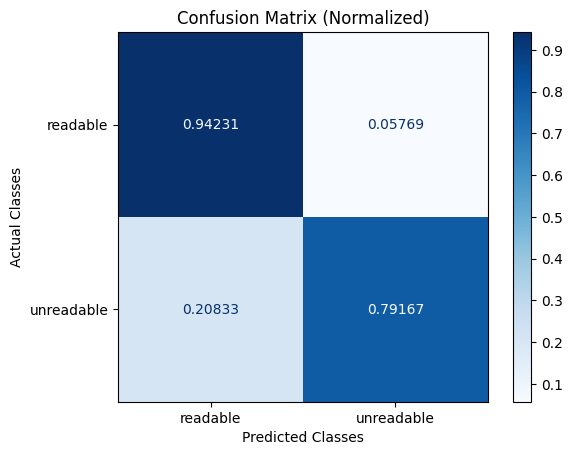

In [20]:
true_labels = df["readable"].map(CODE_READABILITY_PROMPT_OUTPUT_MAP).tolist()
predicted_labels = relevance_classifications
classes = list(CODE_READABILITY_PROMPT_OUTPUT_MAP.values())

print(classification_report(true_labels, predicted_labels, labels=classes))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=predicted_labels, classes=classes
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
);

## Inspecting evaluations

Because the evals are binary classifications, we can easily sample a few rows where the evals deviated from ground truth and see what the actual code was in that case.

In [21]:
df["predicted"] = predicted_labels
# inspect instances where ground truth was readable but evaluated to unreadable by the LLM
filtered_df = df.query('readable == False and predicted == "readable"')

# inspect first 5 rows that meet this condition
pd.set_option("display.max_colwidth", None)
result = filtered_df.head(5)
result

,Unnamed: 0,task_id,query,canonical_solution,test,entry_point,readable,code,predicted
6,110,HumanEval/110,"\ndef exchange(lst1, lst2):\n """"""In this problem, you will implement a function that takes two lists of numbers,\n and determines whether it is possible to perform an exchange of elements\n between them to make lst1 a list of only even numbers.\n There is no limit on the number of exchanged elements between lst1 and lst2.\n If it is possible to exchange elements between the lst1 and lst2 to make\n all the elements of lst1 to be even, return ""YES"".\n Otherwise, return ""NO"".\n For example:\n exchange([1, 2, 3, 4], [1, 2, 3, 4]) => ""YES""\n exchange([1, 2, 3, 4], [1, 5, 3, 4]) => ""NO""\n It is assumed that the input lists will be non-empty.\n """"""\n","odd = 0\n even = 0\n for i in lst1:\n if i%2 == 1:\n odd += 1\n for i in lst2:\n if i%2 == 0:\n even += 1\n if even >= odd:\n return ""YES""\n return ""NO""\n \n","def check(candidate):\n\n # Check some simple cases\n assert candidate([1, 2, 3, 4], [1, 2, 3, 4]) == ""YES""\n assert candidate([1, 2, 3, 4], [1, 5, 3, 4]) == ""NO""\n assert candidate([1, 2, 3, 4], [2, 1, 4, 3]) == ""YES"" \n assert candidate([5, 7, 3], [2, 6, 4]) == ""YES""\n assert candidate([5, 7, 3], [2, 6, 3]) == ""NO"" \n assert candidate([3, 2, 6, 1, 8, 9], [3, 5, 5, 1, 1, 1]) == ""NO""\n\n # Check some edge cases that are easy to work out by hand.\n assert candidate([100, 200], [200, 200]) == ""YES""\n\n",exchange,False,"odd,even=0,0\nfor i in lst1:odd+=1 if i%2 else 0\nfor i in lst2:even+=1 if not i%2 else 0\nreturn 'YES' if even>=odd else 'NO'",readable
18,29,HumanEval/29,"from typing import List\n\n\ndef filter_by_prefix(strings: List[str], prefix: str) -> List[str]:\n """""" Filter an input list of strings only for ones that start with a given prefix.\n >>> filter_by_prefix([], 'a')\n []\n >>> filter_by_prefix(['abc', 'bcd', 'cde', 'array'], 'a')\n ['abc', 'array']\n """"""\n",return [x for x in strings if x.startswith(prefix)]\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate([], 'john') == []\n assert candidate(['xxx', 'asd', 'xxy', 'john doe', 'xxxAAA', 'xxx'], 'xxx') == ['xxx', 'xxxAAA', 'xxx']\n",filter_by_prefix,False,"return list(filter(lambda x: x[:len(prefix)] == prefix, strings))",readable
24,30,HumanEval/30,"\n\ndef get_positive(l: list):\n """"""Return only positive numbers in the list.\n >>> get_positive([-1, 2, -4, 5, 6])\n [2, 5, 6]\n >>> get_positive([5, 3, -5, 2, -3, 3, 9, 0, 123, 1, -10])\n [5, 3, 2, 3, 9, 123, 1]\n """"""\n",return [e for e in l if e > 0]\n,"\n\nMETADATA = {}\n\n\ndef check(candidate):\n assert candidate([-1, -2, 4, 5, 6]) == [4, 5, 6]\n assert candidate([5, 3, -5, 2, 3, 3, 9, 0, 123, 1, -10]) == [5, 3, 2, 3, 3, 9, 123, 1]\n assert candidate([-1, -2]) == []\n assert candidate([]) == []\n\n",get_positive,False,"return list(filter(lambda e: e > 0, l))",readable
43,7,HumanEval/7,"from typing import List\n\n\ndef filter_by_substring(strings: List[str], substring: str) -> List[str]:\n """""" Filter an input list of strings only for ones that contain given substring\n >>> filter_by_substring([], 'a')\n []\n >>> filter_by_substring(['abc', 'bacd', 'cde', 'array'], 'a')\n ['abc', 'bacd', 'array']\n """"""\n",return [x for x in strings if substring in x]\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate([], 'john') == []\n assert candidate(['xxx', 'asd', 'xxy', 'john doe', 'xxxAAA', 'xxx'], 'xxx') == ['xxx', 'xxxAAA', 'xxx']\n assert candidate(['xxx', 'asd', 'aaaxxy', 'john doe', 'xxxAAA', 'xxx'], 'xx') == ['xxx', 'aaaxxy', 'xxxAAA', 'xxx']\n assert candidate(['grunt', 'trumpet', 'prune', 'gruesome'], 'run') == ['grunt', 'prune']\n",filter_by_substring,False,"return list(filter(lambda x: substring in x, strings))",readable
55,66,HumanEval/66,"\ndef digitSum(s):\n """"""Task\n Write a function that takes a string as input and returns the sum of the upper 